#### 1. Load Packages

Notes on Key Changes
Rolling Covariance (get_rolling_cov): We now use risk_models.exp_cov(sub_df, span=window) every day in regime_based_bl_backtest_flatprior().

Fallback in max_sharpe: A new EfficientFrontier(...) is instantiated as ef2 if ef.max_sharpe(...) fails.

Risk Aversion is set to 2.5 in the BlackLittermanModel(...).

Absolute Views remain: absolute_views=dict(zip(assets, view_vector)).

Transaction Cost is 0.0007 = 7 bps (unchanged usage).

One-Day Delay: On day t, we use states_test[t-1] to build a new portfolio, applying it at the end of day t. Meanwhile, the day t-1 returns are realized with the old weights.

Fallback Return = 0.0 for an unseen regime. also fallback function is equal weight rather that minimum volatility.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.special import logsumexp
from joblib import Parallel, delayed
import multiprocessing

# Hidden Markov Model utilities
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans

# PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.black_litterman import BlackLittermanModel

# Sparse Jump Model utilities
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd


#### 2. Data simulation

In [55]:
ASSETS = ["Value", "Growth", "LowVol", "Size", "Momentum", "Quality"]
N_ASSETS = len(ASSETS)

def simulate_1state_data(num_days, seed=None):
    np_rng = np.random.default_rng(seed)
    SIM_MEAN_1STATE = 0.000461
    SIM_SIG_1STATE  = 0.008388

    corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(corr, 1.0)
    cov = np.outer(np.full(N_ASSETS, SIM_SIG_1STATE),
                   np.full(N_ASSETS, SIM_SIG_1STATE)) * corr

    rets = np_rng.multivariate_normal(
        mean=np.full(N_ASSETS, SIM_MEAN_1STATE),
        cov=cov,
        size=num_days
    )
    return pd.DataFrame(rets, columns=ASSETS)


def simulate_2state_data(num_days, seed=None):
    np_rng = np.random.default_rng(seed)
    transmat = np.array([[0.9976, 0.0024],
                         [0.0232, 0.9768]])
    mu_dict  = {0: 0.0006,   1: -0.000881}
    sig_dict = {0: 0.00757, 1: 0.0163}

    base_corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(base_corr, 1.0)

    all_states = np.zeros((num_days, N_ASSETS), dtype=int)
    for i in range(N_ASSETS):
        s = np.zeros(num_days, dtype=int)
        s[0] = np_rng.integers(2)
        for t in range(1, num_days):
            s[t] = np_rng.choice(2, p=transmat[s[t - 1]])
        all_states[:, i] = s

    rets = np.zeros((num_days, N_ASSETS))
    for t in range(num_days):
        mu_vec  = np.zeros(N_ASSETS)
        sig_vec = np.zeros(N_ASSETS)
        for i in range(N_ASSETS):
            curr_state = all_states[t, i]
            mu_vec[i]  = mu_dict[curr_state]
            sig_vec[i] = sig_dict[curr_state]
        cov_t = np.outer(sig_vec, sig_vec) * base_corr
        rets[t] = np_rng.multivariate_normal(mean=mu_vec, cov=cov_t)

    return pd.DataFrame(rets, columns=ASSETS), all_states


def simulate_3state_data(num_days, seed=None):
    np_rng = np.random.default_rng(seed)
    transmat = np.array([
        [0.9989, 0.0004, 0.0007],
        [0.0089, 0.9904, 0.0007],
        [0.0089, 0.0004, 0.9907]
    ])
    mu_list  = [0.0008, 0.0,     -0.003586]
    sig_list = [0.0070, 0.0050,  0.01897]

    base_corr = np.full((N_ASSETS, N_ASSETS), 0.185)
    np.fill_diagonal(base_corr, 1.0)

    all_states = np.zeros((num_days, N_ASSETS), dtype=int)
    for i in range(N_ASSETS):
        s = np.zeros(num_days, dtype=int)
        s[0] = np_rng.integers(3)
        for t in range(1, num_days):
            s[t] = np_rng.choice(3, p=transmat[s[t - 1]])
        all_states[:, i] = s

    rets = np.zeros((num_days, N_ASSETS))
    for t in range(num_days):
        mu_vec  = np.zeros(N_ASSETS)
        sig_vec = np.zeros(N_ASSETS)
        for i in range(N_ASSETS):
            st_i   = all_states[t, i]
            mu_vec[i]  = mu_list[st_i]
            sig_vec[i] = sig_list[st_i]
        cov_t = np.outer(sig_vec, sig_vec) * base_corr
        rets[t] = np_rng.multivariate_normal(mean=mu_vec, cov=cov_t)

    return pd.DataFrame(rets, columns=ASSETS), all_states

#### 3. Training Regime Models

#### 3.1 Hidden Markov Model

In [56]:
def run_mle(observations, n_components=2, init_type='default', seed=None):
    model = GaussianHMM(
        n_components=n_components,
        covariance_type='diag',
        n_iter=100,
        random_state=seed
    )
    if init_type == 'default':
        model.startprob_ = np.array([1.0, 0.0])
        model.transmat_  = np.array([
            [0.9, 0.1],
            [0.1, 0.9]
        ])
        model.means_  = np.zeros((n_components, observations.shape[1]))
        model.covars_ = np.full((n_components, observations.shape[1]), 1e-10)
        model.init_params = ''
    elif init_type == 'kmeans':
        km = KMeans(n_clusters=n_components, n_init=10, random_state=seed)
        labels = km.fit_predict(observations)
        means, covars = [], []
        for i in range(n_components):
            obs_i = observations[labels == i]
            means.append(np.mean(obs_i, axis=0))
            covars.append(np.var(obs_i, axis=0) + 1e-10)
        model.startprob_ = np.ones(n_components) / n_components
        model.transmat_  = np.ones((n_components, n_components)) / n_components
        model.means_     = np.array(means)
        model.covars_    = np.array(covars)
        model.init_params = ''

    model.fit(observations)
    pred_states = model.predict(observations)
    return model, pred_states


def run_mle_default(observations, seed=None):
    return run_mle(observations, init_type='default', seed=seed)


def run_mle_kmeans(observations, seed=None):
    return run_mle(observations, init_type='kmeans', seed=seed)


def train_hmm_single_asset_default(series, n_components=2, random_state=42):
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_default(X, seed=random_state)
    return model


def train_hmm_single_asset_kmeans(series, n_components=2, random_state=42):
    X = series.values.reshape(-1, 1)
    model, _ = run_mle_kmeans(X, seed=random_state)
    return model

#### 3.2 Feature selection and SJM training

In [57]:
def compute_sjm_features(factor_ser: pd.Series) -> pd.DataFrame:
    def ewm_downside_dev(returns: pd.Series, halflife: float) -> pd.Series:
        negative_returns = returns.clip(upper=0)
        neg_sq = negative_returns ** 2
        ewm_mean = neg_sq.ewm(halflife=halflife, adjust=False).mean()
        return np.sqrt(ewm_mean)

    dd20 = ewm_downside_dev(factor_ser, halflife=20)
    dd60 = ewm_downside_dev(factor_ser, halflife=60)
    dd120 = ewm_downside_dev(factor_ser, halflife=120)

    feat_dd20 = dd20
    feat_dd20_minus_dd60 = dd20 - dd60
    feat_dd60_minus_dd120 = dd60 - dd120
    ret_hl120 = factor_ser.ewm(halflife=120, adjust=False).mean()

    feats = {
        "DD_hl20": feat_dd20,
        "DD20_minus_DD60": feat_dd20_minus_dd60,
        "DD60_minus_DD120": feat_dd60_minus_dd120,
        "Return_hl120": ret_hl120,
    }
    df_feats = pd.DataFrame(feats)
    df_feats = df_feats.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return df_feats

In [58]:
def train_sjm_single_asset(series, n_components=2, max_feats=4, lam=50, random_state=42):
    feats_df = compute_sjm_features(series)
    feats_df = feats_df.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScalerPD()

    X_clipped = clipper.fit_transform(feats_df)
    X_scaled  = scaler.fit_transform(X_clipped)
    X_arr = X_scaled.values

    sjm = SparseJumpModel(
        n_components=n_components,
        max_feats=max_feats,
        jump_penalty=lam,
        cont=False,
        max_iter=20,
        random_state=random_state
    )
    sjm.fit(X_arr)

    return sjm, clipper, scaler

#### 4. Allocation simulation

#### 4.1 Backtest a static portfolio with single allocaiton

In [59]:
def backtest_portfolio(
        returns: pd.DataFrame,
        target_weights: np.ndarray,
        transaction_cost: float = 0.0007,
        rebalance_freq: int | None = None,   # 63 ≈ quarterly; None → buy‑and‑hold
        return_weights: bool = False,
        return_trades:  bool = False,
):
    """
    Buy‑and‑hold with optional periodic re‑balancing **after the close**:

    Day‑t sequence
    -------------
    1.  Start‑of‑day weights  w_sod           (already set at yesterday’s close)
    2.  Market move           r_{t}
    3.  End‑of‑day value      pv_t  ← w_sod ⋅ r_t
    4.  If rebalance day → trade to `target_weights`
        (cost paid from pv_t, weights become tomorrow’s w_sod)
    """
    T, _ = returns.shape
    pv   = np.ones(T)
    w    = target_weights.copy()

    W_hist, trades = [w.copy()], []                    # keep history

    # initial buy‑in
    pv[0] -= transaction_cost * np.abs(w).sum()

    for t in range(1, T):
        # ----- 1 & 2 — market move with *start‑of‑day* weights ----------
        ret_vec = returns.iloc[t-1].values            # day‑(t‑1) return
        pv[t]   = pv[t-1] * (1 + np.dot(w, ret_vec))  # end‑of‑day portfolio value

        # ----- drift weights to end‑of‑day position ---------------------
        w *= (1 + ret_vec)
        w /= w.sum()

        # ----- 3 — optional rebalance executed **now** ------------------
        traded_today = 0.0
        if rebalance_freq and t % rebalance_freq == 0:
            traded_today = np.abs(w - target_weights).sum()
            pv[t] -= pv[t] * traded_today * transaction_cost
            w = target_weights.copy()

        W_hist.append(w.copy())
        trades.append(traded_today)

    out = (pv,)
    if return_weights:
        out += (np.asarray(W_hist),)
    if return_trades:
        out += (np.asarray(trades),)
    return out if len(out) > 1 else out[0]

#### 5.0 Performance Metric

In [60]:
def compute_performance_metrics(pv,
                                trade_sizes=None,
                                annual_factor: int = 250):
    """
    Compute standard performance stats.
    `trade_sizes` should be the daily Σ|Δw|; turnover is their mean.
    """
    pv = np.asarray(pv)
    rets = np.diff(pv) / pv[:-1]

    ann_ret = rets.mean() * annual_factor
    cum_ret = pv[-1] / pv[0] - 1
    ann_vol = rets.std() * np.sqrt(annual_factor)

    downside = rets[rets < 0]
    ddev     = downside.std() * np.sqrt(annual_factor) if len(downside) else 0.0
    max_dd   = (pv / np.maximum.accumulate(pv) - 1).min()

    sharpe  = ann_ret / (ann_vol + 1e-12)
    sortino = ann_ret / ddev if ddev > 1e-12 else np.nan
    calmar  = ann_ret / abs(max_dd) if max_dd < 0 else np.nan

    turnover = float(np.mean(trade_sizes)) if trade_sizes is not None else 0.0

    return {"Annualized Return": ann_ret,
            "Cumulative Return": cum_ret,
            "Volatility": ann_vol,
            "Downside Deviation": ddev,
            "Max Drawdown": max_dd,
            "Sharpe Ratio": sharpe,
            "Sortino Ratio": sortino,
            "Calmar Ratio": calmar,
            "Turnover Rate": turnover}

#### 6. Helper Function: get per-regime means & std

In [61]:
def get_regime_means_stds_single_asset(asset_series, regime_assignments):
    """
    Returns two dicts:
      means_dict = {state: mean_return_in_that_state}
      stds_dict  = {state: std_return_in_that_state}
    """
    unique_states = np.unique(regime_assignments)
    regime_means = {}
    regime_stds  = {}
    for s in unique_states:
        data_in_s = asset_series[regime_assignments == s]
        if len(data_in_s) > 0:
            regime_means[s] = data_in_s.mean()
            regime_stds[s]  = data_in_s.std()
        else:
            # Fallback if empty
            regime_means[s] = asset_series.mean()
            regime_stds[s]  = asset_series.std()

    return regime_means, regime_stds

#### 7. Equal Unconditional Prior

In [62]:
def build_equal_unconditional_prior(df_train):
    """
    Build an 'equal unconditional prior' for BL using approximate known
    unconditional values for demonstration. 
    """
    SIM_MEAN_1STATE = 0.000461
    SIM_SIG_1STATE  = 0.008388
    TRUE_CORR       = 0.185

    n_assets = df_train.shape[1]
    uniform_corr = np.full((n_assets, n_assets), TRUE_CORR)
    np.fill_diagonal(uniform_corr, 1.0)

    cov_flat = (SIM_SIG_1STATE**2) * uniform_corr

    assets = df_train.columns
    pi_series = pd.Series(np.full(n_assets, SIM_MEAN_1STATE), index=assets)
    cov_df = pd.DataFrame(cov_flat, index=assets, columns=assets)
    return pi_series, cov_df

In [63]:
def get_rolling_cov(full_returns, current_index, halflife=126):
    """
    Compute an exponentially weighted covariance matrix using all data 
    available up to 'current_index', with an effective halflife equal to 'halflife' days.
    
    The equivalent span parameter is computed as:
        span_equiv = (2 / (1 - exp(-ln(2)/halflife))) - 1
    which ensures that the EWMA decay rate matches the specified halflife.
    
    If there are fewer than 2 data points, an identity matrix is returned.
    """
    # Use all available data from the beginning until current_index
    sub_df = full_returns.iloc[:current_index]
    
    if len(sub_df) < 2:
        n_ = sub_df.shape[1]
        return np.eye(n_)
    
    # Calculate the equivalent span for the desired halflife
    span_equiv = (2 / (1 - np.exp(-np.log(2) / halflife))) - 1
    
    # Compute the exponentially weighted covariance matrix
    cov_est = risk_models.exp_cov(sub_df, span=span_equiv, returns_data=True)
    return cov_est


In [64]:
# --- helper: forward‑filter HMM states (no look‑ahead) ------------------
def filter_hidden_states(model: GaussianHMM, X: np.ndarray) -> np.ndarray:
    """
    Online (α‑recursion) state filter.
    Returns the most‑likely state at each t using data ≤ t only.
    Complexity: O(T · n_states²)
    """
    loglik      = model._compute_log_likelihood(X)
    n_samples   = len(X)
    n_states    = model.n_components
    log_start   = np.log(model.startprob_)
    log_trans   = np.log(model.transmat_)

    alpha = np.empty((n_samples, n_states))
    # t = 0
    alpha[0] = log_start + loglik[0]
    alpha[0] -= logsumexp(alpha[0])

    for t in range(1, n_samples):
        for j in range(n_states):
            alpha[t, j] = loglik[t, j] + logsumexp(alpha[t-1] + log_trans[:, j])
        alpha[t] -= logsumexp(alpha[t])

    return alpha.argmax(axis=1)        # filtered state sequence


#### 8.0 Regime-Based BL with the 'Equal Unconditional Prior'

In [65]:
def regime_based_bl_backtest_flatprior(
        df_train,
        df_test,
        states_test,
        init_state,
        regime_means_list,
        transaction_cost=0.0007,
        risk_free_rate=0.02 / 252,
        bl_tau=0.05,
        halflife=126,
):
    """
    Regime‑switch Black–Litterman back‑test with correct day‑order:
      • day‑t‑1 weights earn day‑t‑1 return
      • rebalance happens after the close of day‑t‑1,  
        so new weights are in place for day‑t.
    """
    T_test   = len(df_test)
    assets   = df_test.columns
    n_assets = len(assets)

    combined = pd.concat([df_train, df_test]).reset_index(drop=True)

    pv        = np.ones(T_test)
    w_prev    = np.ones(n_assets) / n_assets          # weights *at open* of day‑0
    W_hist    = np.zeros((T_test, n_assets))
    W_hist[0] = w_prev.copy()

    trades, fallback = [0.0], []                      # day‑0 trade = 0

    for t in range(1, T_test):
        # ---------- market move on day‑(t‑1) ---------------------------
        r = df_test.iloc[t-1].values
        pv[t] = pv[t-1] * (1 + np.dot(w_prev, r))

        # drift to end‑of‑day weights
        w_eod = w_prev * (1 + r)
        w_eod /= w_eod.sum()

        # ---------- decide if we rebalance after today’s close ---------
        if t == 1:
            current_states = init_state
            do_reb = True
        else:
            current_states = states_test[t-1]
            do_reb = not np.all(states_test[t-1] == states_test[t-2])

        traded_today = 0.0
        if do_reb:
            # --------- build BL target weights -------------------------
            view_vec = np.array([
                regime_means_list[i].get(current_states[i], 0.0)
                for i in range(n_assets)
            ])
            cov_t = get_rolling_cov(combined, len(df_train) + t, halflife)

            bl = BlackLittermanModel(
                    cov_matrix=cov_t,
                    pi="equal",
                    absolute_views=dict(zip(assets, view_vec)),
                    tau=bl_tau,
                    risk_aversion=2.5,
            )
            ef = EfficientFrontier(bl.bl_returns(), cov_t,
                                   weight_bounds=(0, 1), solver="SCS")
            try:
                w_dict = ef.max_sharpe(risk_free_rate=risk_free_rate)
            except ValueError:
                fallback.append({"t": t, "states": current_states.copy()})
                w_dict = {a: 1.0 / n_assets for a in assets}

            w_target = np.array([w_dict[a] for a in assets])

            traded_today = np.abs(w_eod - w_target).sum()
            pv[t] -= pv[t] * traded_today * transaction_cost
            w_prev = w_target                             # weights for tomorrow
        else:
            w_prev = w_eod                                # drifted weights

        W_hist[t] = w_prev
        trades.append(traded_today)

    return pv, W_hist, np.asarray(trades), fallback

#### 9. Wrapper to run all strategies

In [66]:
def equal_weight_allocation(n_assets):
    return np.ones(n_assets)/n_assets

def inverse_vol_weights(returns):
    stds = returns.std(axis=0).values + 1e-12
    w = 1.0/stds
    return w / w.sum()

def static_mvo_allocation(returns, risk_free_rate=0.02/252):
    mu = expected_returns.mean_historical_return(returns, frequency=250)
    raw_cov = risk_models.sample_cov(returns)
    ridge_lambda = 1e-5
    cov = raw_cov + np.eye(len(raw_cov)) * ridge_lambda
    try:
        ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1), solver="SCS")
        w_dict = ef.max_sharpe(risk_free_rate=risk_free_rate)
    except ValueError as e:
        print(f"Falling back to min_volatility due to: {e}")
        ef = EfficientFrontier(mu, cov, weight_bounds=(0,1), solver="SCS")
        w_dict = ef.min_volatility()
    return ef.clean_weights()

In [67]:
# ---------------------------------------------------------------------
# run_allocation – O(T) regime filter, quarterly EW/MVO rebalancing
# ---------------------------------------------------------------------
def run_allocation(
        df,
        lam_sjm=50,
        risk_free_rate=0.02 / 252,
        transaction_cost=0.0007,
        bl_tau=0.05,
):
    split_idx = int(len(df) * 0.8)
    df_train  = df.iloc[:split_idx]
    df_test   = df.iloc[split_idx:]
    T_train, T_test = len(df_train), len(df_test)

    # storage for regime sequences
    hmm_states_default_train = np.zeros((T_train, N_ASSETS), dtype=int)
    hmm_states_kmeans_train  = np.zeros((T_train, N_ASSETS), dtype=int)
    sjm_states_train         = np.zeros((T_train, N_ASSETS), dtype=int)

    hmm_states_default_test  = np.zeros((T_test,  N_ASSETS), dtype=int)
    hmm_states_kmeans_test   = np.zeros((T_test,  N_ASSETS), dtype=int)
    sjm_states_test          = np.zeros((T_test,  N_ASSETS), dtype=int)

    hmm_regime_means_default, hmm_regime_means_kmeans, sjm_regime_means = [], [], []

    # ---------- per‑asset models ---------------------------------------
    for j, a in enumerate(ASSETS):
        full_X = df[a].values.reshape(-1, 1)

        # HMM default
        hmm_d = train_hmm_single_asset_default(df_train[a])
        st_d_full = filter_hidden_states(hmm_d, full_X)
        hmm_states_default_train[:, j] = st_d_full[:split_idx]
        hmm_states_default_test[:,  j] = st_d_full[split_idx:]
        hmm_regime_means_default.append(
            get_regime_means_stds_single_asset(df_train[a], st_d_full[:split_idx])[0])

        # HMM k‑means
        hmm_k = train_hmm_single_asset_kmeans(df_train[a])
        st_k_full = filter_hidden_states(hmm_k, full_X)
        hmm_states_kmeans_train[:, j] = st_k_full[:split_idx]
        hmm_states_kmeans_test[:,  j] = st_k_full[split_idx:]
        hmm_regime_means_kmeans.append(
            get_regime_means_stds_single_asset(df_train[a], st_k_full[:split_idx])[0])

        # SJM
        sjm, clip, scl = train_sjm_single_asset(df_train[a], lam=lam_sjm)
        feats_full = compute_sjm_features(df[a]).fillna(0.0)
        X_full     = scl.transform(clip.transform(feats_full)).values
        st_sjm_full = sjm.predict(X_full)
        sjm_states_train[:, j] = st_sjm_full[:split_idx]
        sjm_states_test[:,  j] = st_sjm_full[split_idx:]
        sjm_regime_means.append(
            get_regime_means_stds_single_asset(df_train[a], st_sjm_full[:split_idx])[0])

    # ---------- static strategies --------------------------------------
    w_ew  = np.ones(N_ASSETS) / N_ASSETS
    pv_ew,  _, T_ew  = backtest_portfolio(
        df_test, w_ew, transaction_cost,
        rebalance_freq=63,
        return_weights=True,          # FIX
        return_trades=True)

    w_iv  = inverse_vol_weights(df_test)
    pv_iv, _, T_iv  = backtest_portfolio(
        df_test, w_iv, transaction_cost,
        return_weights=True,          # FIX
        return_trades=True)

    w_mvo = np.array([static_mvo_allocation(df_train, risk_free_rate)[a]
                      for a in df_train.columns])
    pv_mvo, _, T_mvo = backtest_portfolio(
        df_test, w_mvo, transaction_cost,
        rebalance_freq=63,
        return_weights=True,          # FIX
        return_trades=True)

    # ---------- regime‑based BL ----------------------------------------
    pv_hmm_d, _, T_hmm_d, fb_d = regime_based_bl_backtest_flatprior(
        df_train, df_test, hmm_states_default_test,
        hmm_states_default_train[-1], hmm_regime_means_default,
        transaction_cost, risk_free_rate, bl_tau, 126)

    pv_hmm_k, _, T_hmm_k, fb_k = regime_based_bl_backtest_flatprior(
        df_train, df_test, hmm_states_kmeans_test,
        hmm_states_kmeans_train[-1], hmm_regime_means_kmeans,
        transaction_cost, risk_free_rate, bl_tau, 126)

    pv_sjm,   _, T_sjm,   fb_sjm = regime_based_bl_backtest_flatprior(
        df_train, df_test, sjm_states_test,
        sjm_states_train[-1], sjm_regime_means,
        transaction_cost, risk_free_rate, bl_tau, 126)

    # ---------- metrics ------------------------------------------------
    perf = {
        "EW":  compute_performance_metrics(pv_ew,  trade_sizes=T_ew ),
        "IV":  compute_performance_metrics(pv_iv,  trade_sizes=T_iv ),
        "MVO": compute_performance_metrics(pv_mvo, trade_sizes=T_mvo),
        "HMM-BL-Default": compute_performance_metrics(pv_hmm_d, trade_sizes=T_hmm_d),
        "HMM-BL-KMeans":  compute_performance_metrics(pv_hmm_k, trade_sizes=T_hmm_k),
        "SJM-BL":         compute_performance_metrics(pv_sjm  , trade_sizes=T_sjm ),
    }

    fallbacks = {"HMM-BL-Default": fb_d,
                 "HMM-BL-KMeans":  fb_k,
                 "SJM-BL":         fb_sjm}
    return perf, fallbacks


#### 10. FUll scenario 1-state, 2-state, 3-state

In [68]:
def run_scenario_123(
    T_sim=1000,
    lam_sjm=50,
    risk_free_rate=0.02/252,
    transaction_cost=0.0007,
    bl_tau=0.05,
    seed1=None,
    seed2=None,
    seed3=None
):
    df1_full = simulate_1state_data(T_sim, seed=seed1)
    perf_1 = run_allocation(
        df1_full,
        lam_sjm=lam_sjm,
        risk_free_rate=risk_free_rate,
        transaction_cost=transaction_cost,
        bl_tau=bl_tau
    )

    df2_full, _ = simulate_2state_data(T_sim, seed=seed2)
    perf_2 = run_allocation(
        df2_full,
        lam_sjm=lam_sjm,
        risk_free_rate=risk_free_rate,
        transaction_cost=transaction_cost,
        bl_tau=bl_tau
    )

    df3_full, _ = simulate_3state_data(T_sim, seed=seed3)
    perf_3 = run_allocation(
        df3_full,
        lam_sjm=lam_sjm,
        risk_free_rate=risk_free_rate,
        transaction_cost=transaction_cost,
        bl_tau=bl_tau
    )

    return {
        "1state": perf_1,
        "2state": perf_2,
        "3state": perf_3
    }


def single_monte_carlo_run(
    run_id,
    T_sim=1000,
    lam_sjm=50,
    risk_free_rate=0.02/252,
    transaction_cost=0.0007,
    bl_tau=0.05
):
    print(f"Running simulation {run_id}...")
    seed_for_1state = run_id * 1000 + 11
    seed_for_2state = run_id * 1000 + 22
    seed_for_3state = run_id * 1000 + 33

    results = run_scenario_123(
        T_sim=T_sim,
        lam_sjm=lam_sjm,
        risk_free_rate=risk_free_rate,
        transaction_cost=transaction_cost,
        bl_tau=bl_tau,
        seed1=seed_for_1state,
        seed2=seed_for_2state,
        seed3=seed_for_3state
    )
    return results


def run_monte_carlo_study(
    n_runs=10,
    T_sim=1000,
    lam_sjm=50,
    risk_free_rate=0.02/252,
    transaction_cost=0.0007,
    bl_tau=0.05
):
    print(f"Detected {multiprocessing.cpu_count()} cores")
    all_results = Parallel(n_jobs=-1)(
        delayed(single_monte_carlo_run)(
            i+1, T_sim, lam_sjm, risk_free_rate, transaction_cost, bl_tau
        )
        for i in range(n_runs)
    )

    strategies = ["EW", "IV", "MVO", "HMM-BL-Default", "HMM-BL-KMeans", "SJM-BL"]
    scenarios  = ["1state", "2state", "3state"]

    sharpe_data = {sc: {st: [] for st in strategies} for sc in scenarios}
    all_metrics = {sc: {} for sc in scenarios}
    for sc in scenarios:
        all_metrics[sc] = {}
        for st in strategies:
            all_metrics[sc][st] = {
                "Annualized Return": [],
                "Cumulative Return": [],
                "Volatility": [],
                "Downside Deviation": [],
                "Max Drawdown": [],
                "Sharpe Ratio": [],
                "Sortino Ratio": [],
                "Calmar Ratio": [],
                "Turnover Rate": [],
            }

    # Gather distribution of metrics
    for run_res in all_results:
        for sc in scenarios:
            # Unpack the tuple (perf, fallback_events)
            perf, fallback_events = run_res[sc]
            for st in strategies:
                metrics_dict = perf[st]
                sharpe_data[sc][st].append(metrics_dict["Sharpe Ratio"])
                for mkey in all_metrics[sc][st]:
                    all_metrics[sc][st][mkey].append(metrics_dict[mkey])

    # Wilcoxon tests
    print("\n==== Wilcoxon Tests (SJM-BL vs. others) ====")
    wilcoxon_rows = []
    for sc in scenarios:
        sjm_sharpes = sharpe_data[sc]["SJM-BL"]
        for st in strategies:
            if st == "SJM-BL":
                continue
            other_sharpes = sharpe_data[sc][st]
            try:
                stat, pval = wilcoxon(sjm_sharpes, other_sharpes, alternative='two-sided')
            except ValueError:
                stat, pval = np.nan, np.nan
            print(f"{sc} | SJM-BL vs {st}: stat={stat:.4f}, p={pval:.4g}")
            wilcoxon_rows.append({
                "Scenario": sc,
                "Comparison": f"SJM-BL vs {st}",
                "Statistic": stat,
                "p-value": pval
            })

    df_wilcoxon = pd.DataFrame(wilcoxon_rows)
    print("\nWilcoxon Results Table:")
    print(df_wilcoxon.to_string(index=False))

    # Print average metrics
    print("\n==== Average Performance Metrics (across runs) ====")
    for sc in scenarios:
        rows = []
        for st in strategies:
            metric_means = {}
            for mkey, vals in all_metrics[sc][st].items():
                metric_means[mkey] = np.mean(vals)
            row = {"Strategy": st}
            row.update(metric_means)
            rows.append(row)
        df_avg = pd.DataFrame(rows)
        df_avg.set_index("Strategy", inplace=True)
        print(f"\n--- {sc.upper()} ---")
        print(df_avg.to_string())

    return sharpe_data, all_metrics, all_results, df_wilcoxon

#### Main Exectution

In [69]:
if __name__ == "__main__":
    config = {
        "n_simulations": 500,
        "T_sim": 5040,
        "risk_free_rate": 0.02 / 252,
        "transaction_cost": 0.0007,  # 7 bps
        "bl_tau": 0.05,
        "lam_sjm": 100,
    }

    sharpe_data, all_metrics, all_runs, df_wilcoxon = run_monte_carlo_study(
        n_runs=config["n_simulations"],
        T_sim=config["T_sim"],
        lam_sjm=config["lam_sjm"],
        risk_free_rate=config["risk_free_rate"],
        transaction_cost=config["transaction_cost"],
        bl_tau=config["bl_tau"]
    )

    # Fallback summary loop now uses all_runs
    fallback_summary = []
    for run in all_runs:
        for scenario in run:  # "1state", "2state", "3state"
            # Unpack the tuple to get fallback_events (second element)
            _, fallback_dict = run[scenario]
            for strat, events in fallback_dict.items():
                for event in events:
                    record = event.copy()
                    record.update({
                        "Scenario": scenario,
                        "Strategy": strat
                    })
                    fallback_summary.append(record)
    if fallback_summary:
        df_fallback = pd.DataFrame(fallback_summary)
        print("\n==== Fallback Events Summary ====")
        print(df_fallback.to_string(index=False))
    else:
        print("\nNo fallback events recorded.")

Detected 16 cores

==== Wilcoxon Tests (SJM-BL vs. others) ====
1state | SJM-BL vs EW: stat=37947.0000, p=2.263e-14
1state | SJM-BL vs IV: stat=39933.0000, p=2.213e-12
1state | SJM-BL vs MVO: stat=19876.0000, p=6.256e-40
1state | SJM-BL vs HMM-BL-Default: stat=27525.0000, p=1.806e-27
1state | SJM-BL vs HMM-BL-KMeans: stat=408.0000, p=1.457e-82
2state | SJM-BL vs EW: stat=53184.0000, p=0.003491
2state | SJM-BL vs IV: stat=57566.0000, p=0.1176
2state | SJM-BL vs MVO: stat=16528.0000, p=3.816e-46
2state | SJM-BL vs HMM-BL-Default: stat=14853.0000, p=1.988e-49
2state | SJM-BL vs HMM-BL-KMeans: stat=18692.0000, p=4.482e-42
3state | SJM-BL vs EW: stat=11142.0000, p=4.081e-57
3state | SJM-BL vs IV: stat=49214.0000, p=3.339e-05
3state | SJM-BL vs MVO: stat=8880.0000, p=4.418e-62
3state | SJM-BL vs HMM-BL-Default: stat=14699.0000, p=9.789e-50
3state | SJM-BL vs HMM-BL-KMeans: stat=15728.0000, p=1.067e-47

Wilcoxon Results Table:
Scenario               Comparison  Statistic      p-value
  1state

In [70]:
import pickle
import pandas as pd

# Save non-DataFrame objects using pickle
results = {
    "sharpe_data": sharpe_data,
    "all_metrics": all_metrics,
    "all_runs": all_runs,
    "df_wilcoxon": df_wilcoxon
}

with open("simulation_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Save fallback summary DataFrame to a CSV file, if available
if fallback_summary:
    df_fallback.to_csv("fallback_events_summary.csv", index=False)
    
# Optionally, if df_wilcoxon is a DataFrame, you can also save it as CSV
if isinstance(df_wilcoxon, pd.DataFrame):
    df_wilcoxon.to_csv("wilcoxon_results.csv", index=False)

print("All simulation data has been saved.")


All simulation data has been saved.


In [3]:
import pickle

# Load the main results dict
with open("simulation_results.pkl", "rb") as f:
    results = pickle.load(f)

sharpe_data   = results["sharpe_data"]
all_metrics   = results["all_metrics"]
all_runs      = results["all_runs"]
df_wilcoxon   = results["df_wilcoxon"]

# Load fallback events summary, if it exists
try:
    df_fallback = pd.read_csv("fallback_events_summary.csv")
except FileNotFoundError:
    df_fallback = None

# Optionally load the Wilcoxon CSV version (or fall back to the DataFrame in pickle)
try:
    df_wilcoxon_csv = pd.read_csv("wilcoxon_results.csv", index_col=False)
except FileNotFoundError:
    df_wilcoxon_csv = df_wilcoxon

print("Keys in results:", list(results.keys()))
print("Fallback events loaded:", df_fallback is not None)
print("Wilcoxon DataFrame shape:", df_wilcoxon_csv.shape)

Keys in results: ['sharpe_data', 'all_metrics', 'all_runs', 'df_wilcoxon']
Fallback events loaded: False
Wilcoxon DataFrame shape: (15, 4)


In [4]:
# --- A) Average performance metrics across runs ---
rows = []
for scenario, strategies in all_metrics.items():
    for strategy, metrics in strategies.items():
        avg_metrics = {
            metric: sum(values) / len(values) if values else float('nan')
            for metric, values in metrics.items()
        }
        avg_metrics.update({
            "Scenario": scenario,
            "Strategy": strategy
        })
        rows.append(avg_metrics)

df_avg_metrics = pd.DataFrame(rows).set_index(["Scenario", "Strategy"])

print("=== Average Performance Metrics ===")
print(df_avg_metrics)

# --- B) Wilcoxon test results table ---
print("\n=== Wilcoxon Test Results ===")
# Ensure we only show the key columns
print(df_wilcoxon[["Scenario", "Comparison", "Statistic", "p-value"]])

=== Average Performance Metrics ===
                         Annualized Return  Cumulative Return  Volatility  Downside Deviation  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Turnover Rate
Scenario Strategy                                                                                                                                                    
1state   EW                       0.113799           0.581831    0.075121            0.043931     -0.081636      1.514902       2.602320      1.602370       0.000653
         IV                       0.114211           0.584512    0.075443            0.044136     -0.081982      1.513894       2.599751      1.600029       0.000000
         MVO                      0.113702           0.582674    0.092881            0.054628     -0.111613      1.240044       2.122194      1.224335       0.000528
         HMM-BL-Default           0.108192           0.546346    0.076791            0.045162     -0.086938      1.409049       2.4081

=== Average Performance Metrics (no IV) ===
                       Annualized Return  Cumulative Return  Volatility  Downside Deviation  Max Drawdown  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Turnover Rate
Scenario Strategy                                                                                                                                                  
1state   EW                     0.113799           0.581831    0.075121            0.043931     -0.081636      1.514902       2.602320      1.602370       0.000653
         MVO                    0.113702           0.582674    0.092881            0.054628     -0.111613      1.240044       2.122194      1.224335       0.000528
         HMM_MLE_BL             0.108192           0.546346    0.076791            0.045162     -0.086938      1.409049       2.408174      1.446016       0.032056
         HMM_MLE_k_BL           0.093095           0.455276    0.077006            0.045298     -0.093936      1.209051       2.067182  

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


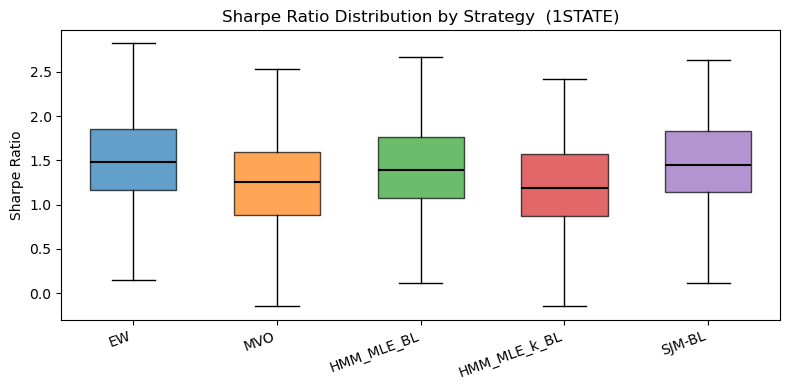

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


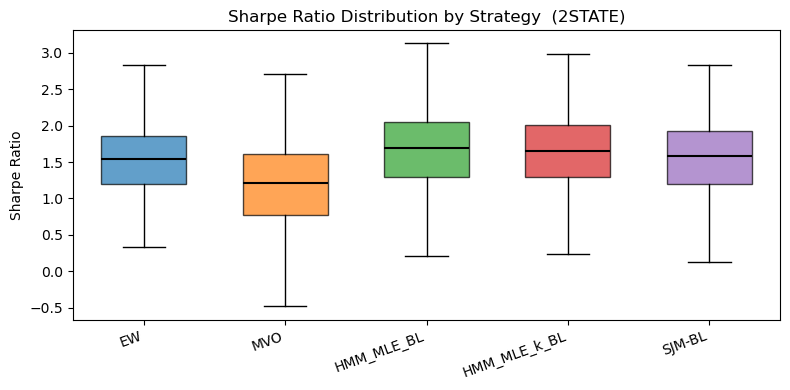

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


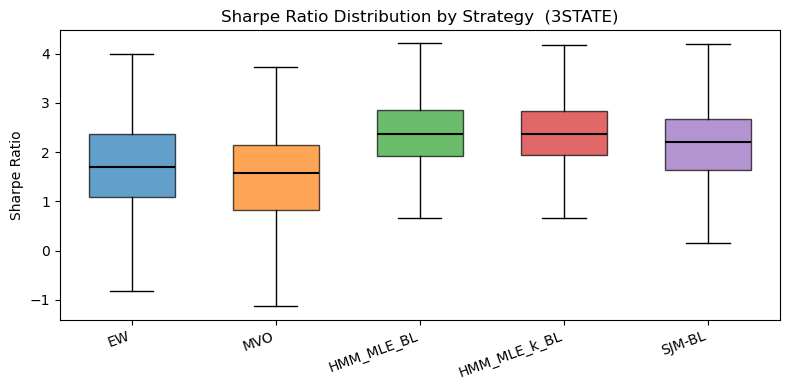

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


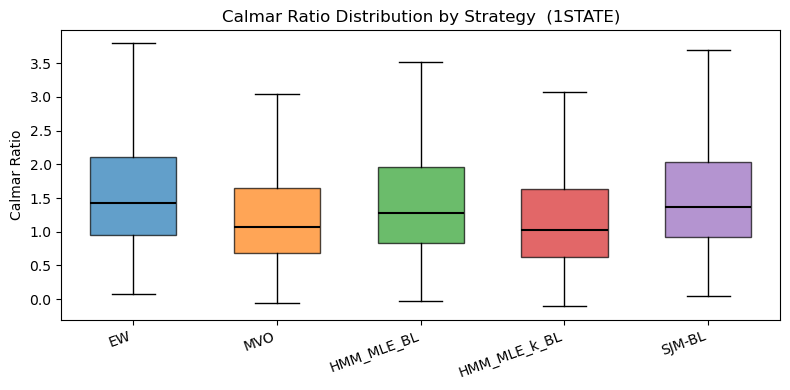

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


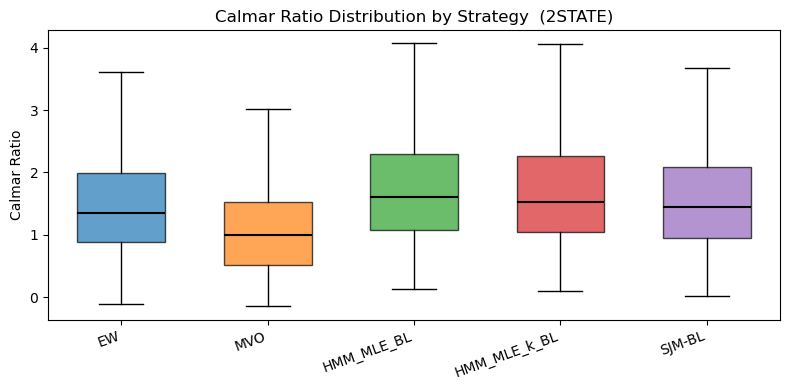

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


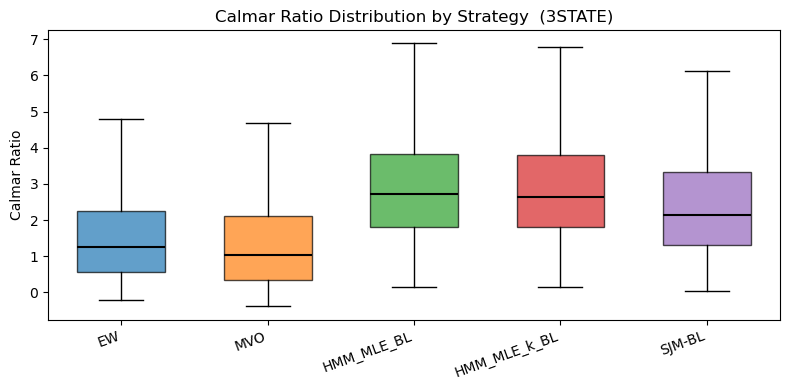

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


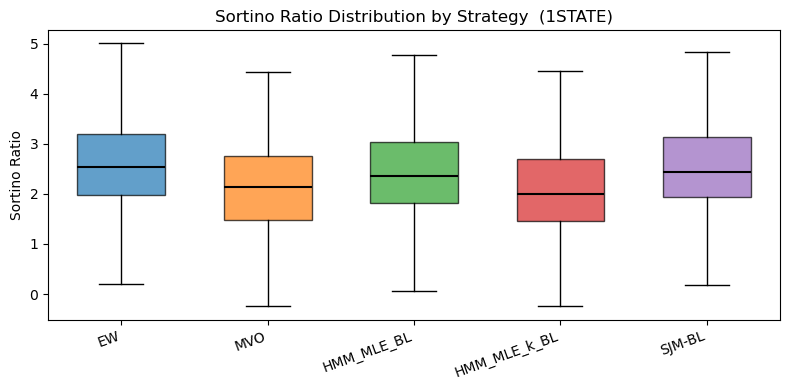

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


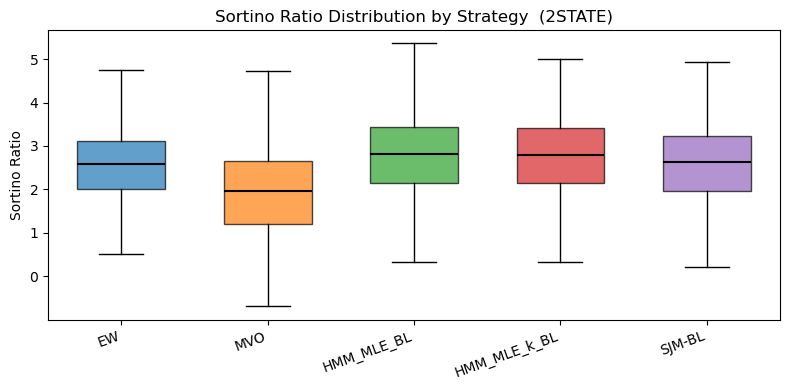

C:\Users\vri\AppData\Local\Temp\ipykernel_22016\3035356558.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


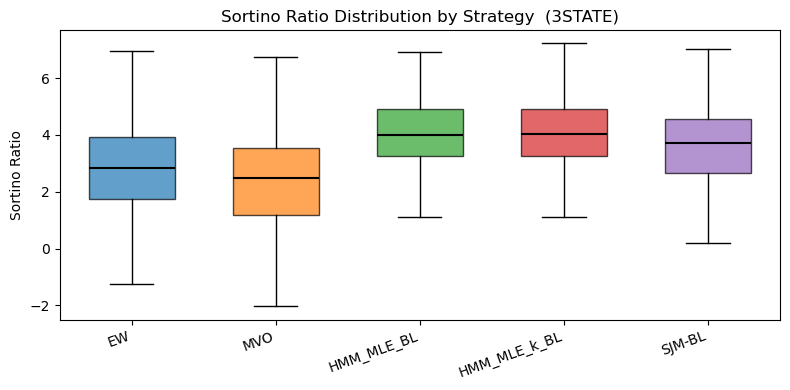

In [9]:
# ### 1.0 Load Packages

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# %% [markdown]
# ### 2.0 Load Simulation Results

# %%
with open("simulation_results.pkl", "rb") as f:
    results = pickle.load(f)

all_metrics = results["all_metrics"]
df_wilcoxon = results["df_wilcoxon"]

# %% [markdown]
# ### 3.0 Define Strategies, Mappings & Metrics

# %%
# legacy keys in all_metrics → new labels
legacy_strats = ["EW", "MVO", "HMM-BL-Default", "HMM-BL-KMeans", "SJM-BL"]
new_labels   = ["EW", "MVO", "HMM_MLE_BL", "HMM_MLE_k_BL", "SJM-BL"]
label_map    = dict(zip(legacy_strats, new_labels))

scenarios      = ["1state", "2state", "3state"]
metrics_to_plot = ["Sharpe Ratio", "Calmar Ratio", "Sortino Ratio"]

# %% [markdown]
# ### 4.0 Average Performance Metrics Table (no IV, renamed)

# %%
rows = []
for sc, strat_dict in all_metrics.items():
    for strat_old, metr in strat_dict.items():
        if strat_old == "IV":
            continue
        # compute means
        avg = { m: np.mean(metr[m]) for m in metr }
        rows.append({
            **avg,
            "Scenario": sc,
            "Strategy": label_map.get(strat_old, strat_old)
        })

df_avg = pd.DataFrame(rows).set_index(["Scenario", "Strategy"])
print("=== Average Performance Metrics (no IV) ===")
print(df_avg.to_string())

# %% [markdown]
# ### 5.0 Wilcoxon Test Results (no IV comparisons)

# %%
df_w = df_wilcoxon[~df_wilcoxon["Comparison"].str.contains("IV")]
print("\n=== Wilcoxon Test Results (no IV) ===")
print(df_w[["Scenario","Comparison","Statistic","p-value"]].to_string(index=False))

# %% [markdown]
# ### 6.0 Box‑Plots by Scenario (with renamed labels)

# %%
for metric in metrics_to_plot:
    for sc in scenarios:
        # gather data in legacy order, then relabel
        data   = [ all_metrics[sc][s_old][metric] for s_old in legacy_strats ]
        labels = [ label_map[s_old]              for s_old in legacy_strats ]

        plt.figure(figsize=(8, 4))
        bp = plt.boxplot(
            data,
            labels=labels,
            patch_artist=True,
            showfliers=False,
            widths=0.6
        )
        # match your palette
        colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple"]
        for box, col in zip(bp["boxes"], colors):
            box.set_facecolor(col)
            box.set_alpha(0.7)
        for med in bp["medians"]:
            med.set(color="black", linewidth=1.5)

        plt.title(f"{metric} Distribution by Strategy  ({sc.upper()})")
        plt.ylabel(metric)
        plt.xticks(rotation=20, ha="right")
        plt.tight_layout()
        plt.show()